In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

global L,T, tau, h

L = 1
T = 1

h = 0.1 
tau = 0.00005

N = int(L/h)
M = int(T/tau)


N,M

(10, 20000)

# Описание задачи
XIII.11.16 
Уравнение ФитцХью–Нагумо, описывающее распространение нервного импульса Несколько различных математических моделей, предназначенных для описания распространения нервного импульса в одномерной системе, носят название моделей ФитцХью–Нагумо. Исторически считается, что данные модели возникли из интерполяции наборов экспериментальных данных. Так как в годы создания модели была сильно развита радиотехника, вполне вероятной представляется гипотеза что нелинейность в данной системе «позаимствована» из хорошо известной радиотехникам модели Ван-дер-Поля. Главное, что в такой системе реализуется случай колебательной потери устойчивости, решение – бегущий импульс, форму которого можно подобрать так, чтобы его форма была близка к тому, что в действительности фиксируется в физиологических экспериментах. Пример одного из видов моделей ФитцХью–Нагумо:
$$
\frac{\partial u}{\partial t} = u(a - u)(u - 1) - v + I + D\frac{{\partial}^2u}{\partial x^2},
$$
$$
\frac{\partial v}{\partial t} = bu - \gamma v.
$$


# Задание

Требуется исследовать характер особых точек точечной системы в зависимости от параметров. Определить область параметров, когда в си- стеме возможно распространение бегущих волн (волн переключения, см. задачи XIII.11.1–4).
Проанализировать случай. когда в системе положение равновесие единственное и возможно распространение «бегущего импульса». В фазовом пространстве задачи в переменных «бегущей волны» такому импуль- су соответствует сепаратрисса, идущая из седла в это же седло.
Построить и реализовать неявную разностную схему для решения нелинейной системы уравнений в частных производных.

# Предварительное знакоство с задачей
Перепишим уравнение в новом виде:
$$
\frac{\partial u}{\partial t} = f(u) - v + I + D\frac{{\partial}^2u}{\partial x^2},
$$
$$
\frac{\partial v}{\partial t} = bu - \gamma v,
$$
$$
f(u)= u(a - u)(u - 1).
$$



Распространение импульса в случае надпорогового (а) и подпорогового (б) воздействия: а) при начальном отклонении потенциала больше пороговой величины u = a в системе возникает бегущий импульс, который распространяется вдоль нерва без изменения формы (уединенная волна); точки A, B, C, D соответствуют точкам на фазовом портрете 18.3а; б) при начальном отклонении потенциала в точке возбуждения меньше пороговой величины u = a (точка P на рис. 18.3а) бегущий импульс быстро затухает 

![Image of Yaktocat](1.png)

Для упрощения качественного рассмотрения будем считать b и $\gamma$ малыми:

$$
b = \varepsilon L, \gamma = \varepsilon M, 0<\varepsilon<1
$$

При $I_a = 0$ и $\varepsilon \rightarrow 0$, $v = const$. Мы приходим к одному уравнению для потенциала $u$:
$$
\frac{\partial u}{\partial t} = f(u) + D\frac{{\partial}^2u}{\partial x^2}
$$

#Точное решение
В нашем случае будем считать ($D = 1$), тогда точное решение выглядит:
$$
w(x,t) = \frac{1}{1+ Aexp[\pm\frac{1}{2}\sqrt{2}x + \frac{1}{2}(2a-1)t]}
$$ 
Подберем начальные условия так, чтобы: $A = 1$. Тогда (считаем $0<x<1,0<t<1$) 
$$
w(x,0) = \frac{1}{1+e^{\pm\frac{1}{2}\sqrt{2}x}} 
$$
$$
w(0,t) = \frac{1}{1+e^{\frac{1}{2}(2a-1)t}} 
$$
$$
w(1,t) = \frac{1}{1+e^{\pm\frac{1}{2}\sqrt{2}+\frac{1}{2}(2a-1)t}} 
$$

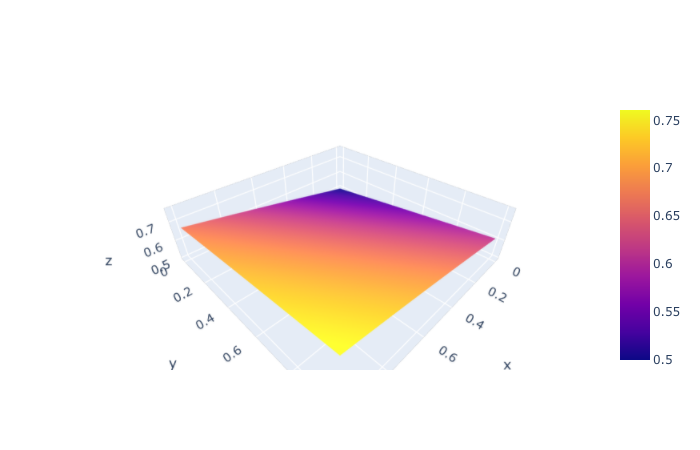

In [2]:
def f_right (u, a = 0.05):
    return u*(a-u)*(u-1)

def accurate_w(grid, a = 0.05):
    w = 1/(1 + np.exp(-1/2*np.sqrt(2)*grid[0]+ 1/2 * (2*a-1)*grid[1]))
    return w
    
def result(N,M):

    x = np.linspace(0,L,N, endpoint=True)
    t = np.linspace(0,T,M, endpoint=True)

    grid = np.meshgrid(x, t)
    trueresult = np.array(accurate_w(grid))

    return trueresult

fig = go.Figure(go.Surface(z = result(N,M), x = np.linspace(0,1,N), y = np.linspace(0,1,M)))
fig.show("png")

# Разностные схемы

Будем использвать три разностные схемы:

1. Явная схема
2. Неявная схема
3. Неявная схема с весами $\sigma = 1/2$



## Явная схема

![](1_1.png)


In [3]:
def explicit_y_up (i,j,data, f): #явная схема для одгого шага
    
    y_centaral = data[j][i]
    y_left = data[j][i-1]
    y_right = data[j][i+1]
    
    y_up = y_centaral + tau/(h**2) * (y_right - 2 * y_centaral + y_left) + tau * f(y_centaral)

    return y_up

def create_data (N,M,f): #создание сетки с начальными условиями
    data = np.zeros([M,N])
    
    for i in range (N):
        data[0][i] = f([i*h,0])

    for i in range (M):
        data[i][0] = f([0,i*tau])
        data[i][N-1] = f([N*h,i*tau])

    return data

def explicit_data(N,M,f_accur,f_right): #явная схема для всех шагов
    
    data = create_data(N,M,f_accur)
    for j in range(M-1):
        for i in range(1,N-1):
             data[j+1,i] = explicit_y_up(i,j,data,f_right)
    return data

### Описание функций
для всех функций $h, \tau$ задаются глобально.

1. `create_data (N,M,f)` - создает массив, с граничными условиями. Принимает количество точек (N  по x, M по y), f - функция для определения граничных значений
2. `explicit_y_up (i,j,data, f)` - явная схема для одного шага, принимает номер шага (i - шаг по x, j - шаг по y), $f$ - функция неоднородности 
3. `explicit_data(N,M,f_accur,f_right)` - явная схема для заполнения массива. Принимает кол-во точек, точное решение (для определения граничных условий), функция для неоднородности.

### Выводы
Можно заметить, что максимальная невязка $\sim h^2$ (хотя относительно $\tau$ получается не очень). Также отметим, что $\tau < h^2/2$. Иначе схема неустойчива.

## Неявная схема
![](2.png)

Отметим, что схема абсолютно устойчива. Поэтому увеличим $\tau$ до $h$

In [4]:
global tau_2, h_2,N_2,M_2 

h_2 = 0.01 
tau_2 = h_2/2

N_2 = int(L/h_2)
M_2 = int(T/tau_2)

Для нахождения значений на новом слое.
![](2_2.png)




In [5]:
def solve_tdm(a, b, c, f): # методо прогонки 
    n = len(a)
    P = np.zeros(n); Q = np.zeros(n); x = np.zeros(n); P[0] = -c[0] / b[0]
    Q[0] = f[0] / b[0]
    
    for k in range(n-1):
        P[k+1] = -c[k+1] / (a[k+1] * P[k] + b[k+1])
        Q[k+1] = (f[k+1] - a[k+1] * Q[k]) / (a[k+1] * P[k] + b[k+1]) 
    
    x[n-1] = Q[n-1]
    for k in reversed(range(n-1)): 
        x[k] = P[k] * x[k+1] + Q[k]
    return x

def non_explicit_y_up (N,j,data, f): #неявная схема для одгого шага
    
    F = np.zeros(N-1)
    for i in range(1,N-1):
        y_centaral = data[j][i]
        y_left = data[j][i-1]
        y_right = data[j][i+1]

        F[i] = y_centaral + tau_2*f(y_centaral) + tau_2/(2*h_2**2)*(y_right - 2 * y_centaral + y_left)
        

    A = B = tau_2/(2*h_2**2)
    
    C = 1 + 2*A
    
    A = np.ones(N-1) *A
    B = np.ones(N-1) *B
    C = np.ones(N-1) *C

    return solve_tdm(A,-C, B, -F)

def non_explicit_data(N,M,f_accur,f_right): #неявная схема для всех шагов
    
    data = create_data(N,M,f_accur)
    for j in range(M-1):
        data[j+1,1:-1] = non_explicit_y_up(N-1,j,data,f_right)
        
    return data

In [ ]:
test = non_explicit_data(N_2,M_2,accurate_w,f_right)


In [ ]:
np.max(np.abs(test-result(N_2,M_2)))

### Выводы:
Не смотря на то, что неявный метод абсолютно устойчиевый, и можно добиться высокой апроксимации (например неявная схема с весами, реализуется аналогично, только другие коэффициенты), но из-за сложности O(n^2), вычесления проходят достаточно долго

# Правило Рунге
## Явная схема
Давайте проверим правило рунге, а также построим графики

In [6]:
h_test = 0.1/2
 
N_mass_explicit = []
M_mass_explicit = []

for i in range (1,4):
    
    h_new = h_test/i
    tau_new = h_new**2/4 # тау = h^2/4
    
    N_new = 1/h_new
    M_new = 1/tau_new

    N_mass_explicit.append(int(N_new))
    M_mass_explicit.append(int(M_new))


result_explicit = np.array([explicit_data(N_mass_explicit[i],M_mass_explicit[i],accurate_w,f_right) for i in range(3)])
result_accurate= np.array([result(N_mass_explicit[i],M_mass_explicit[i]) for i in range(3)]) # посчитали точное решение и явной схемы на 3 разынх сетках 

delta = np.abs(result_accurate-result_explicit) 

delta_max = [np.max(delta[i]) for i in range(3)] # находим максимальное отколенние для кадой сетки



In [10]:
z = np.abs(result_explicit[1] - result_accurate[1][100])

In [8]:
b = np.abs(result_explicit[2][100][5] - result_accurate[2][100][5])

In [9]:
np.log(b/a)/np.log(2) # p 

NameError: name 'a' is not defined

In [ ]:
i = 0
N = N_mass_explicit[i]
M = M_mass_explicit[i]
fig = go.Figure(go.Surface(z = explicit_data(N,M,accurate_w,f_right), x = np.linspace(0,1,N), y = np.linspace(0,1,M)))
fig.show()

In [11]:
z.shape

(6399, 40)

Формула для p
$$
p = ln\frac{\Delta x_1}{\Delta x_2} \cdot \frac{1}{ln(2)}
$$

In [48]:
np.log(delta_max[1]/delta_max[2])/np.log(2) # p 

-0.7289068654822548

### Выводы
p примерно совпало с теорий (1)

### Графики


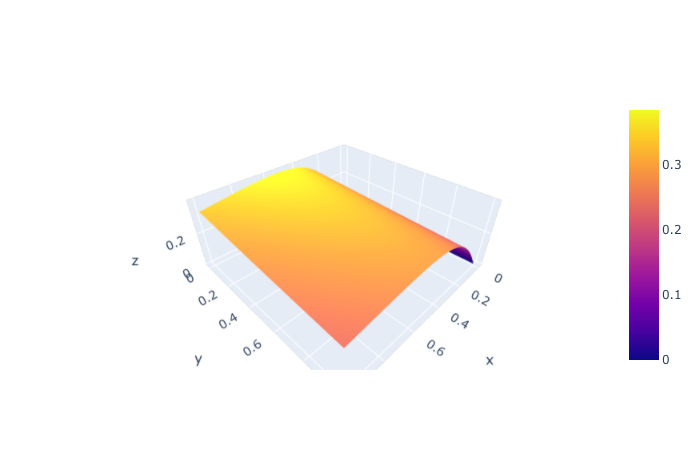

In [15]:
k = 0
x = np.linspace(0,1,N_mass_explicit[k])
y = np.linspace(0,1,M_mass_explicit[k])
fig = go.Figure(go.Surface(z = delta[0], x = x,y = y)) #график для отклонения
fig.show("png")

## Неявная схема
Продублируем код

In [26]:
h_test = 0.001/2

 
N_mass_non_explicit = []
M_mass_non_explicit = []

for i in range (1,4):
    
    h_new = h_test/i
    tau_new = h_new # тау = h
    
    N_new = 1/h_new
    M_new = 1/tau_new

    N_mass_non_explicit.append(int(N_new))
    M_mass_non_explicit.append(int(M_new))


result_non_explicit = np.array([non_explicit_data(N_mass_non_explicit[i],M_mass_non_explicit[i],accurate_w,f_right) for i in range(3)])
result_accurate= np.array([result(N_mass_non_explicit[i],M_mass_non_explicit[i]) for i in range(3)]) # посчитали точное решение и явной схемы на 3 разынх сетках 

delta_non = np.abs(result_accurate-result_non_explicit) 

delta_non_max = [np.max(delta_non[i]) for i in range(3)] # находим максимальное отколенние для кадой сетки

KeyboardInterrupt: 

In [ ]:
delta_non_max

In [ ]:
np.log(delta_non_max[2]/delta_non_max[1])/np.log(2) # p 

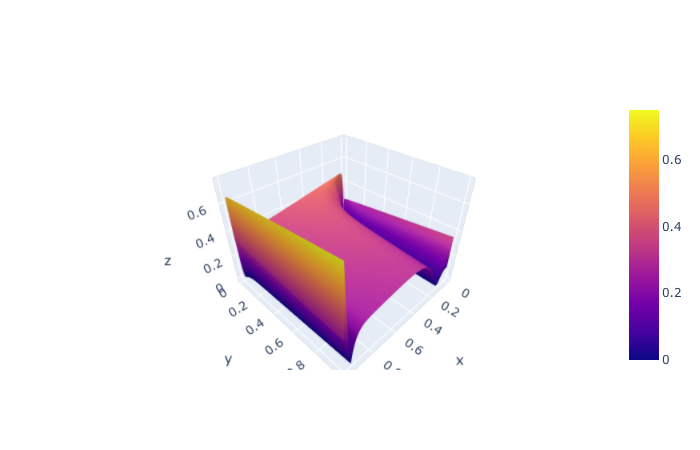

In [20]:

k = 0
x = np.linspace(0,1,N_mass_non_explicit[k])
y = np.linspace(0,1,M_mass_non_explicit[k])
fig = go.Figure(go.Surface(z = delta_non[k], x = x,y = y)) #график для отклонения
fig.show("png")

In [ ]:

k = 0
x = np.linspace(0,1,N_mass_non_explicit[k])
y = np.linspace(0,1,M_mass_non_explicit[k])
fig = go.Figure(go.Surface(z = _non[k], x = x,y = y)) #график для отклонения
fig.show("png")